# Matminer introduction - Predicting bulk modulus

This notebook demonstrates some of the basic features of matminer.

This notebook was last updated 02/04/25. 


## Overview
In this notebook, we will:
1. Load and examine a dataset in a pandas dataframe
2. Add descriptors to the dataframe using matminer
3. Train, compare, and visualize several machine learning methods with scikit-learn and matminer FigRecipes.



## 1. Load and process data set

Matminer comes pre-loaded with several example data sets you can use. Below, we'll load a data set of computed elastic properties of materials which is sourced from the paper:  "Charting the complete elastic properties of inorganic crystalline compounds", M. de Jong *et al.*, Sci. Data. 2 (2015) 150009.

In [1]:
from matminer.datasets.convenience_loaders import load_elastic_tensor
df = load_elastic_tensor()  # loads dataset in a pandas DataFrame object

## 1.1 A first look at the data set

The data set comes as a pandas DataFrame, which is a kind of "spreadsheet" object in Python. DataFrames have several useful methods you can use to explore and clean the data, some of which we'll explore below.

In [2]:
df.head()

,material_id,formula,nsites,space_group,volume,structure,elastic_anisotropy,G_Reuss,G_VRH,G_Voigt,K_Reuss,K_VRH,K_Voigt,poisson_ratio,compliance_tensor,elastic_tensor,elastic_tensor_original
0,mp-10003,Nb4CoSi,12,124,194.419802,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,96.844535,97.141604,97.438674,194.267623,194.268884,194.270146,0.285701,"[[0.004385293093993, -0.0016070693558990002, -...","[[311.33514638650246, 144.45092552856926, 126....","[[311.33514638650246, 144.45092552856926, 126...."
1,mp-10010,Al(CoSi)2,5,164,61.987320,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,93.939650,96.252006,98.564362,173.647763,175.449907,177.252050,0.268105,"[[0.0037715428949660003, -0.000844229828709, -...","[[306.93357350984974, 88.02634955100905, 105.6...","[[306.93357350984974, 88.02634955100905, 105.6..."
2,mp-10015,SiOs,2,221,25.952539,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,120.962289,130.112955,139.263621,295.077545,295.077545,295.077545,0.307780,"[[0.0019959391925840004, -0.000433146670736000...","[[569.5291276937579, 157.8517489654999, 157.85...","[[569.5291276937579, 157.8517489654999, 157.85..."
3,mp-10021,Ga,4,63,76.721433,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,12.205989,15.101901,17.997812,49.025963,49.130670,49.235377,0.360593,"[[0.021647143908635, -0.005207263618160001, -0...","[[69.28798774976904, 34.7875015216915, 37.3877...","[[70.13259066665267, 40.60474945058445, 37.387..."
4,mp-10025,SiRu2,12,62,160.300999,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,100.110773,101.947798,103.784823,255.055257,256.768081,258.480904,0.324682,"[[0.00410214297725, -0.001272204332729, -0.001...","[[349.3767766177825, 186.67131003104407, 176.4...","[[407.4791016459293, 176.4759188081947, 213.83..."


## 1.2 Add a new column to the pandas dataframe
- Volume per atom as a new descriptor: volume_per_atom = volume/nsites

In [3]:
df["volume_per_atom"] = df['volume']/df['nsites']

# Verify the added column
df.head()

,material_id,formula,nsites,space_group,volume,structure,elastic_anisotropy,G_Reuss,G_VRH,G_Voigt,K_Reuss,K_VRH,K_Voigt,poisson_ratio,compliance_tensor,elastic_tensor,elastic_tensor_original,volume_per_atom
0,mp-10003,Nb4CoSi,12,124,194.419802,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,96.844535,97.141604,97.438674,194.267623,194.268884,194.270146,0.285701,"[[0.004385293093993, -0.0016070693558990002, -...","[[311.33514638650246, 144.45092552856926, 126....","[[311.33514638650246, 144.45092552856926, 126....",16.201650
1,mp-10010,Al(CoSi)2,5,164,61.987320,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,93.939650,96.252006,98.564362,173.647763,175.449907,177.252050,0.268105,"[[0.0037715428949660003, -0.000844229828709, -...","[[306.93357350984974, 88.02634955100905, 105.6...","[[306.93357350984974, 88.02634955100905, 105.6...",12.397464
2,mp-10015,SiOs,2,221,25.952539,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,120.962289,130.112955,139.263621,295.077545,295.077545,295.077545,0.307780,"[[0.0019959391925840004, -0.000433146670736000...","[[569.5291276937579, 157.8517489654999, 157.85...","[[569.5291276937579, 157.8517489654999, 157.85...",12.976269
3,mp-10021,Ga,4,63,76.721433,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,12.205989,15.101901,17.997812,49.025963,49.130670,49.235377,0.360593,"[[0.021647143908635, -0.005207263618160001, -0...","[[69.28798774976904, 34.7875015216915, 37.3877...","[[70.13259066665267, 40.60474945058445, 37.387...",19.180358
4,mp-10025,SiRu2,12,62,160.300999,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,100.110773,101.947798,103.784823,255.055257,256.768081,258.480904,0.324682,"[[0.00410214297725, -0.001272204332729, -0.001...","[[349.3767766177825, 186.67131003104407, 176.4...","[[407.4791016459293, 176.4759188081947, 213.83...",13.358417


## 1.3 Removing unneeded columns from the data set

The data set above has many columns - we won't need all this data for our modeling. We'll mainly be trying to predict ``K_VRH`` and ``G_VRH`` (the Voight-Reuss-Hill average of the bulk and shear modulus, respectively) and the ``elastic_anisotropy``. We can drop most of the other output data. We also don't need various metadata such as the ``cif`` string of the structure since the crystal structure is already embedded in the ``structure`` column.

In [4]:
df.columns

Index(['material_id', 'formula', 'nsites', 'space_group', 'volume',
       'structure', 'elastic_anisotropy', 'G_Reuss', 'G_VRH', 'G_Voigt',
       'K_Reuss', 'K_VRH', 'K_Voigt', 'poisson_ratio', 'compliance_tensor',
       'elastic_tensor', 'elastic_tensor_original', 'volume_per_atom'],
      dtype='object')

In [5]:
unwanted_columns = ["volume", "nsites", "volume_per_atom", "compliance_tensor", "elastic_tensor", 
                    "elastic_tensor_original", "K_Voigt", "G_Voigt", "K_Reuss", "G_Reuss"]
df = df.drop(unwanted_columns, axis=1)

In [6]:
df.head()

,material_id,formula,space_group,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio
0,mp-10003,Nb4CoSi,124,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701
1,mp-10010,Al(CoSi)2,164,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,96.252006,175.449907,0.268105
2,mp-10015,SiOs,221,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,130.112955,295.077545,0.307780
3,mp-10021,Ga,63,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,15.101901,49.130670,0.360593
4,mp-10025,SiRu2,62,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,101.947798,256.768081,0.324682


## 1.4 Getting a feel for the data using descriptive statistics

A pandas DataFrame includes a function called ``describe()`` that helps determine statistics for the various numerical / categorical columns in the data.

In [7]:
df.describe()

,space_group,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio
count,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000
mean,163.403895,2.145013,67.543145,136.259661,0.287401
std,65.040733,19.140097,44.579408,72.886978,0.062177
min,4.000000,0.000005,2.722175,6.476135,0.042582
25%,124.000000,0.145030,34.117959,76.435350,0.249159
50%,193.000000,0.355287,59.735163,130.382766,0.290198
75%,221.000000,0.923117,91.332142,189.574194,0.328808
max,229.000000,397.297866,522.921225,435.661487,0.467523


Sometimes, the ``describe()`` function will reveal outliers that indicate mistakes in the data. For example, negative hence unphysical minimum bulk/shear moduli or maximum bulk/shear moduli that are too high. In this case, the data looks ok at first glance; meaing that there are no clear problems with the ranges of the various properties. Therefore, and we won't filter out any data.

Note that the ``describe()`` function only describes numerical columns by default.

# 2. Add descriptors to the data ("featurization")

We are seeking to find relationships between the inputs (composition and crystal structure of a material) and outputs (elastic properties such as ``K_VRH``, ``G_VRH``, and ``elastic_anisotropy``). To find such relations, we need to "featurize" the input data such that they are numbers that meaningfully represent the underlying physical quantity. For example, one "feature" or "descriptor" of the composition of a material such as ``Nb4CoSi`` would be the standard deviation of the Pauling electronegativity of the elements in the compound (weighted by stoichiometry). Compositions with high values of this quantity would be more ionic and quantities with lower values would tend towards covalent or ionic. A descriptor of the crystal structure might be the average coordination number of sites; higher coordination numbers indicate more bonds and therefore might indicate stiffer materials. With matminer, we can start generating hundreds of possible descriptors using the descriptor library that is available. Data mining techniques can help narrow down which descriptors are the most relevant to the target problem using the available output data as a guide.

## 2.1 Add composition-based features

A major class of featurizers available in matminer uses the chemical composition to featurize the input data. Let's add some composition based features to our DataFrame.

The first step is to have a column representing the chemical composition as a pymatgen Composition object. One way to do this is to use the conversions Featurizers in matminer to turn a String composition (our ``formula`` column from before) into a pymatgen Composition.

In [8]:
from matminer.featurizers.conversions import StrToComposition
df = StrToComposition().featurize_dataframe(df, "formula")
df.head()

/Users/rhennig/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
StrToComposition: 100%|██████████| 1181/1181 [00:00<00:00, 24878.32it/s]


,material_id,formula,space_group,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition
0,mp-10003,Nb4CoSi,124,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)"
1,mp-10010,Al(CoSi)2,164,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,96.252006,175.449907,0.268105,"(Al, Co, Si)"
2,mp-10015,SiOs,221,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,130.112955,295.077545,0.307780,"(Si, Os)"
3,mp-10021,Ga,63,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,15.101901,49.130670,0.360593,(Ga)
4,mp-10025,SiRu2,62,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,101.947798,256.768081,0.324682,"(Si, Ru)"


As you can see, we now have a new Composition column above. The visualization in the DataFrame is not so clear, but the column embeds both the elements *and* the amounts of each element in the composition (not shown).

In [9]:
# Print the composition field of the first material in the dataset
df["composition"].iloc[0]

Composition('Nb4 Co1 Si1')

Next, we'll use one of the featurizers in matminer to add a suite of descriptors to the DataFrame.

In [10]:
from matminer.featurizers.composition import ElementProperty

ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition")  # input the "composition" column to the featurizer
df.head()

/Users/rhennig/miniconda3/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
ElementProperty: 100%|██████████| 1181/1181 [00:20<00:00, 56.60it/s]


,material_id,formula,space_group,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,mp-10003,Nb4CoSi,124,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)",14.0,...,1.548471,0.258079,0.430131,0.0,194.0,229.0,35.0,222.833333,9.611111,229.0
1,mp-10010,Al(CoSi)2,164,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,96.252006,175.449907,0.268105,"(Al, Co, Si)",13.0,...,1.548471,0.619388,0.743266,0.0,194.0,227.0,33.0,213.400000,15.520000,194.0
2,mp-10015,SiOs,221,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,130.112955,295.077545,0.307780,"(Si, Os)",14.0,...,0.000000,0.000000,0.000000,0.0,194.0,227.0,33.0,210.500000,16.500000,194.0
3,mp-10021,Ga,63,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,15.101901,49.130670,0.360593,(Ga),31.0,...,0.000000,0.000000,0.000000,0.0,64.0,64.0,0.0,64.000000,0.000000,64.0
4,mp-10025,SiRu2,62,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,101.947798,256.768081,0.324682,"(Si, Ru)",14.0,...,0.000000,0.000000,0.000000,0.0,194.0,227.0,33.0,205.000000,14.666667,194.0


As you can see, we now have many more columns in the DataFrame (a total of 141 columns - not all are shown). So we added *many* features to our data!

As an aside, note that each featurizer also has a ``citations()`` function that tells you where to find out more about the Featurizer.

In [11]:
ep_feat.citations()

['@article{ward_agrawal_choudary_wolverton_2016, title={A general-purpose machine learning framework for predicting properties of inorganic materials}, volume={2}, DOI={10.1038/npjcompumats.2017.28}, number={1}, journal={npj Computational Materials}, author={Ward, Logan and Agrawal, Ankit and Choudhary, Alok and Wolverton, Christopher}, year={2016}}']

## 2.2 Add more composition-based features

There are many more Composition based featurizers apart from ``ElementProperty`` that are available in the ``matminer.featurizers.composition``. Let's try the ``ElectronegativityDiff`` featurizer which requires knowing the oxidation state of the various elements in the Composition. This information is not there currently, but one can use the ``conversions`` package to try to guess oxidation states and then apply the ``ElectronegativityDiff`` featurizer to this column.

In [12]:
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates

df = CompositionToOxidComposition().featurize_dataframe(df, "composition")

os_feat = OxidationStates()
df = os_feat.featurize_dataframe(df, "composition_oxid")
df.head()

OxidationStates: 100%|██████████| 1181/1181 [00:13<00:00, 90.36it/s] 


,material_id,formula,space_group,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition,MagpieData minimum Number,...,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state
0,mp-10003,Nb4CoSi,124,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)",14.0,...,229.0,35.0,222.833333,9.611111,229.0,"(Nb0+, Co0+, Si0+)",0,0,0,0.000000
1,mp-10010,Al(CoSi)2,164,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,96.252006,175.449907,0.268105,"(Al, Co, Si)",13.0,...,227.0,33.0,213.400000,15.520000,194.0,"(Al3+, Co2+, Co3+, Si4-)",-4,3,7,3.872983
2,mp-10015,SiOs,221,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,130.112955,295.077545,0.307780,"(Si, Os)",14.0,...,227.0,33.0,210.500000,16.500000,194.0,"(Si4-, Os4+)",-4,4,8,5.656854
3,mp-10021,Ga,63,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,15.101901,49.130670,0.360593,(Ga),31.0,...,64.0,0.0,64.000000,0.000000,64.0,(Ga0+),0,0,0,0.000000
4,mp-10025,SiRu2,62,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,101.947798,256.768081,0.324682,"(Si, Ru)",14.0,...,227.0,33.0,205.000000,14.666667,194.0,"(Si4-, Ru2+)",-4,2,6,4.242641


As you can see, the end of our data frame has now has some oxidation state based features!

## 2.3 Add some structure based features

Not all featurizers operate on compositions. Matminer can also analyze crystal structures and featurize those as well. Let's start by adding some simple density features.

In [13]:
from matminer.featurizers.structure import DensityFeatures

df_feat = DensityFeatures()
df = df_feat.featurize_dataframe(df, "structure")  # input the structure column to the featurizer
df.head()

DensityFeatures: 100%|██████████| 1181/1181 [00:32<00:00, 36.58it/s] 


,material_id,formula,space_group,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition,MagpieData minimum Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state,density,vpa,packing fraction
0,mp-10003,Nb4CoSi,124,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)",14.0,...,9.611111,229.0,"(Nb0+, Co0+, Si0+)",0,0,0,0.000000,7.834556,16.201654,0.688834
1,mp-10010,Al(CoSi)2,164,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,96.252006,175.449907,0.268105,"(Al, Co, Si)",13.0,...,15.520000,194.0,"(Al3+, Co2+, Co3+, Si4-)",-4,3,7,3.872983,5.384968,12.397466,0.644386
2,mp-10015,SiOs,221,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,130.112955,295.077545,0.307780,"(Si, Os)",14.0,...,16.500000,194.0,"(Si4-, Os4+)",-4,4,8,5.656854,13.968635,12.976265,0.569426
3,mp-10021,Ga,63,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,15.101901,49.130670,0.360593,(Ga),31.0,...,0.000000,64.0,(Ga0+),0,0,0,0.000000,6.036267,19.180359,0.479802
4,mp-10025,SiRu2,62,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,101.947798,256.768081,0.324682,"(Si, Ru)",14.0,...,14.666667,194.0,"(Si4-, Ru2+)",-4,2,6,4.242641,9.539514,13.358418,0.598395


In [14]:
df_feat.feature_labels()

['density', 'vpa', 'packing fraction']

Again, we see more features in the last few columns: ``density``, ``vpa``, and ``packing fraction``.

There are many more structure based featurizers that are much more complex and detailed analysis of the crystal structure that are outside of the scope of this example. Let's move on to doing some machine learning predictions.

# 3. Machine learning models to relate input features to the bulk modulus

We now have enough data to do some machine learning! We'll need to first determine what columns we consider input (independent variables) and what column we consider output (dependent variable).

## 3.1 Define input data and output data

For now, we'll use ``K_VRH`` (bulk modulus) as the output. You could retry this example with ``G_VRH``, ``elastic_anisotropy``, or ``poisson_ratio`` as the target output.

For the inputs, we'll use all the features we generated. That is, everything except the output data and non-numerical columns like ``composition`` and ``structure``.



In [15]:
y = df['K_VRH'].values
excluded = ["G_VRH", "K_VRH", "elastic_anisotropy", "formula", "material_id", 
            "poisson_ratio", "structure", "composition", "composition_oxid"]
X = df.drop(excluded, axis=1)
print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

There are 140 possible descriptors:

['space_group' 'MagpieData minimum Number' 'MagpieData maximum Number'
 'MagpieData range Number' 'MagpieData mean Number'
 'MagpieData avg_dev Number' 'MagpieData mode Number'
 'MagpieData minimum MendeleevNumber' 'MagpieData maximum MendeleevNumber'
 'MagpieData range MendeleevNumber' 'MagpieData mean MendeleevNumber'
 'MagpieData avg_dev MendeleevNumber' 'MagpieData mode MendeleevNumber'
 'MagpieData minimum AtomicWeight' 'MagpieData maximum AtomicWeight'
 'MagpieData range AtomicWeight' 'MagpieData mean AtomicWeight'
 'MagpieData avg_dev AtomicWeight' 'MagpieData mode AtomicWeight'
 'MagpieData minimum MeltingT' 'MagpieData maximum MeltingT'
 'MagpieData range MeltingT' 'MagpieData mean MeltingT'
 'MagpieData avg_dev MeltingT' 'MagpieData mode MeltingT'
 'MagpieData minimum Column' 'MagpieData maximum Column'
 'MagpieData range Column' 'MagpieData mean Column'
 'MagpieData avg_dev Column' 'MagpieData mode Column'
 'MagpieData minimum Row' 'Magpi

## 3.1 Try a linear regression model using scikit-learn

The scikit-learn library makes it easy to fit and cross-validate different types of regression models. Let's start with one of the simplest - a linear regression.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression()

lr.fit(X, y)

# get fit statistics
print('training R2 = ' + str(round(lr.score(X, y), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X))))

training R2 = 0.928
training RMSE = 19.611


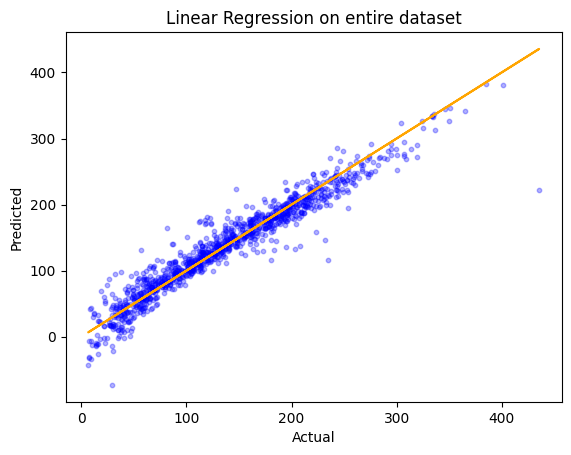

In [17]:
# Visualize the linear regression model on the training and testing data
import matplotlib.pyplot as plt

plt.scatter(y, lr.predict(X), c='blue', s=10, alpha=0.3)
plt.plot(y, y, '-', c='orange')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Linear Regression on entire dataset')
plt.show()

This looks reasonable. However, to really know how well a machine learning model does, we need to ensure that we are not over-fitting. We need to test the model's prediction on previously unseen data.

There are different ways to measure the accuracy of a machine learning model:
- One can split the data into a **training and testing dataset**.
- To see how different splits of the data into training and testing affect the testing error, we can use **cross-validation**.



## 3.2 Splitting data into training and testing

The 80/20 split of data into training and testing sets is a common practice in machine learning model development. Here's a step-by-step description:

### Data Preparation:

- Start with your complete dataset, which includes both features (input variables) and labels (target variable).
- Splitting the Data:
  - Divide the dataset into two parts:
  - Training Set: 80% of the data.
  - Testing Set: 20% of the data.

### Training Set:

- The training set is used to train the machine learning model. The model learns the patterns and relationships in the data during this phase.
- The training set should be representative of the overall dataset to ensure the model generalizes well.

### Testing Set:

- The testing set is used to evaluate the performance of the trained model. It acts as new, unseen data to test how well the model predicts outcomes.
- The testing set helps in assessing the model's accuracy, precision, recall, and other performance metrics.

### Implementation in Python:

You can use the train_test_split function from the sklearn.model_selection module to perform the split. Here is an example:

In [18]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train and y_train will be used for training the model
# X_test and y_test will be used for testing the model

In [19]:
# Fit the model on the training data
lr.fit(X_train, y_train)

# get fit statistics on the training data
print('training R2 = ' + str(round(lr.score(X, y), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X))))

training R2 = 0.924
training RMSE = 20.050


In [20]:
# Test the model on the test data
print('testing R2 = ' + str(round(lr.score(X_test, y_test), 3)))
print('testing RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=lr.predict(X_test))))

testing R2 = 0.904
testing RMSE = 22.530


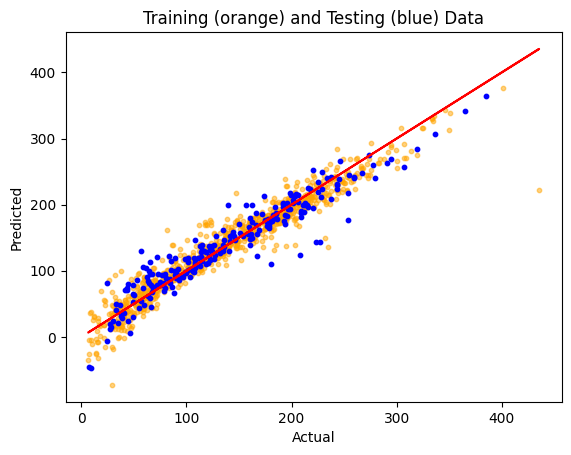

In [21]:
# Visualize the linear regression model on the training and testing data
import matplotlib.pyplot as plt

plt.scatter(y_train, lr.predict(X_train), c='orange', s=10, alpha=0.5)
plt.scatter(y_test, lr.predict(X_test), c='blue', s=10)
plt.plot(y, y, 'r-')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Training (orange) and Testing (blue) Data')
plt.show()


## 3.3 Bias and Variance of machine learning models

The difference in training and testing error for a machine learning model provides insights into the model's performance and its ability to generalize to new, unseen data. This difference can be understood in terms of **bias** and **variance**, which are key concepts in machine learning.

1. **Training Error**:
   - The error calculated on the training set indicates how well the model fits the training data.
   - A low training error suggests that the model has learned the patterns in the training data well.

2. **Testing Error**:
   - The error calculated on the testing set indicates how well the model **generalizes to new, unseen data**.
   - A low testing error suggests that the model performs well on data it has not seen before.

### Bias and Variance:

- **Bias**:
  - Bias refers to the error introduced by approximating a real-world problem, which may be complex, by a simplified model.
  - High bias can cause the model to miss relevant relations between features and target outputs (underfitting).

- **Variance**:
  - Variance refers to the model's sensitivity to small fluctuations in the training set.
  - High variance can cause the model to model the random noise in the training data rather than the intended outputs (overfitting).

### Scenarios and Interpretations:

1. **Low Training Error and Low Testing Error**:
   - The model performs well on both the training and testing sets.
   - Indicates low bias and low variance.
   - The model is likely well-tuned and not overfitting or underfitting.

2. **Low Training Error and High Testing Error**:
   - The model performs well on the training set but poorly on the testing set.
   - Indicates low bias but high variance (overfitting).
   - The model has learned the training data too well, including noise and outliers, and fails to generalize to new data.
   - Solutions: Simplify the model, use regularization techniques, or gather more training data.

3. **High Training Error and High Testing Error**:
   - The model performs poorly on both the training and testing sets.
   - Indicates high bias and low variance (underfitting).
   - The model is too simple to capture the underlying patterns in the data.
   - Solutions: Increase model complexity, add more features, or use a different model.

4. **High Training Error and Low Testing Error**:
   - This scenario is rare and usually indicates an issue with the data or the way the model is evaluated.
   - It might suggest that the training data is not representative of the testing data or there is a data leakage issue.

### Conclusion:
By comparing the training and testing errors, you can diagnose whether your linear regression model is suffering from high bias (underfitting), high variance (overfitting), or is well-tuned. This comparison helps in making informed decisions about model adjustments, such as changing the model complexity, adding regularization, or improving the quality and quantity of the training data. Understanding the balance between bias and variance is crucial for developing a model that generalizes well to new data.

# Linear Regression: A High Bias Model

## What is Bias in Machine Learning?
In machine learning, **bias** refers to the error introduced by approximating a real-world problem with a simplified model. A **high bias** model makes strong assumptions about the data, leading to **underfitting**.

## Why is Linear Regression High Bias?
1. **Strong Assumptions** – Linear regression assumes a **linear relationship** between input features and the target variable, which may not always hold.
2. **Limited Flexibility** – Since it only captures linear patterns, it cannot model complex, **nonlinear** relationships effectively.
3. **Underfitting** – Due to its simplicity, linear regression may not capture the underlying structure of the data, leading to **systematic errors**.

## Why is Linear Regression Low Variance?
1. **Stable Predictions** – Small changes in the dataset do not drastically alter predictions, making it a **low variance** model.
2. **Avoids Overfitting** – Unlike complex models (e.g., deep learning or high-degree polynomial regression), linear regression does not overfit easily.
3. **Few Parameters** – With fewer parameters, it generalizes well but lacks flexibility.

## When is Linear Regression Not High Bias?
- If the **true relationship** is **linear**, then linear regression performs well with **low bias**.
- Adding **polynomial features** or interaction terms can **increase flexibility** and reduce bias.

## Summary
| **Property**          | **Linear Regression** |
|-----------------------|----------------------|
| Bias                 | High                 |
| Variance             | Low                  |
| Underfitting Risk    | High                 |
| Overfitting Risk     | Low                  |
| Flexibility          | Limited (linear)     |

### Conclusion
Linear regression is a **high bias, low variance** model that works well when the true relationship is **linear**. However, for **nonlinear relationships**, it may underfit, leading to poor performance.
